# Batch Normalization


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

**关于实现层的基础设计模式**
1. 用一个单独的函数定义其数学原理，比如 `batch norm` 中实现了规范化的公式
2. 将上述功能集成到一个自定义层中，代码主要处理数据移动到训练设备，如GPU、分配和初始化各种所需变量、跟踪平均移动线（这里是均值和方差）等问题。因为这里需要指定整个特征的数量，所以不用担心自动推断输入形状

创建一个 `batch normalization` 层，在训练时会更新 $\gamma$ 和 $\beta$ 两个参数

更新并返回移动平均法求得的均值和方差

In [3]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    if not torch.is_grad_enabled():
        # 判断是否处于训练模式
        # 测试模式下，直接使用传入的移动平均法求得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            # 全连接层
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 卷积层
            mean = X.mean(dim=(0,2,3),keepdim=True) # 对channels、heigth和weight
            var = ((X - mean) ** 2).mean(dim=(0,2,3),keepdim=True)
        # 训练模式下，用当前的均值和方差
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均法的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
        
    Y = gamma * X_hat + beta # 缩放和移位
    
    return Y,moving_mean.data,moving_var.data

In [7]:
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1,num_features,1,1)
        # 参与梯度迭代的参数
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self,X):
        # 若是 X 不在内存中，将moving_mean和moving_var复制到X所在的显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新的moving_mean和moving_var
        Y,self.moving_mean,self.moving_var = batch_norm(
            X,self.gamma,self.beta,self.moving_mean,
            self.moving_var,eps=1e-5,momentum=0.9)
        return Y
        

使用批量规范化的 `LeNet`

In [8]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),BatchNorm(6,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*4*4,120),BatchNorm(120,num_dims=2),nn.Sigmoid(),
    nn.Linear(120,84),BatchNorm(84,num_dims=2),nn.Sigmoid(),
    nn.Linear(84,10))

# 训练
数据集：`Fashion MNIST`

loss 0.259, train acc 0.905, test acc 0.885
7166.8 examples/sec on cpu


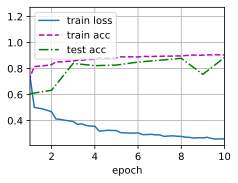

In [9]:
lr,num_epochs,batch_size = 1.0,10,256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

查看第一个批量规范化层的拉伸参数 $\gamma$ 和偏移参数 $\beta$

In [10]:
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([0.6656, 2.8961, 3.4067, 2.8365, 3.0468, 4.3118],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 1.1734,  1.8377,  1.1817, -2.1910, -3.3640, -2.5521],
        grad_fn=<ReshapeAliasBackward0>))